In [9]:
%pylab notebook
from pandas import *
rcParams['axes.grid'] = True
from struct import unpack

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [1]:
with open('velo1_raw.dat', 'rb') as f:
    rawdat = f.read()

In [11]:
import struct

In [56]:
def hd(bs):
    for i, b in enumerate(bs):
        if len(bs) > 16 and (i % 16) == 0:
            print(f'\n{i:%04x}', end='')
        print(f'{b:02x} ', end='')
        

In [64]:
hd(int.to_bytes(1603420459, 4, 'little'))

2b 41 92 5f 

In [74]:
i = 0
dats = []
dats.append(unpack("Iiii", rawdat[i: i + 16]))
while i < len(rawdat) - 17:
    i += 16
    tmp1 = unpack("Iiii", rawdat[i: i + 16])
    if chr(rawdat[i]) != '\n':
        dats.append(tmp1)
        continue
    tmp2 = unpack("Iiii", rawdat[i + 1: i + 17])
    if abs(tmp2[0] - dats[-1][0]) < abs(tmp1[0] - dats[-1][0]):
        i += 1
        dats.append(tmp2)
    else:
        dats.append(tmp1) 

vals = vstack(dats)

In [ ]:
with open('veloLog.txt', 'r') as f:
    ls = f.readlines()

# Hex string to numpy array (unix time stamps)
vals = zeros((len(ls), 4), dtype=int)
for i, l in enumerate(ls):
    bs = bytes.fromhex(l)
    vals[i, :] = [int.from_bytes(bs[i * 4: (i + 1) * 4], byteorder='little', signed=i > 0) for i in range(4)]

In [75]:
# numpy array to pandas dataframe
tss = to_datetime(vals[:, 0], unit='s', utc=True).tz_convert('US/Pacific')
df = DataFrame(vals, index=tss, columns=('ts', 'mV', 'mA', 'cnt'))
df

,ts,mV,mA,cnt
2020-10-21 22:43:25-07:00,1603345405,7148,-32,3
2020-10-21 22:43:04-07:00,1603345384,7148,-17,0
2020-10-21 22:43:05-07:00,1603345385,7148,-49,0
2020-10-21 22:43:06-07:00,1603345386,7148,-49,0
2020-10-21 22:43:07-07:00,1603345387,7156,-42,0
...,...,...,...,...
2020-10-24 16:05:34-07:00,1603580734,7260,-19,55741
2020-10-24 16:05:35-07:00,1603580735,7260,-19,55741
2020-10-24 16:05:36-07:00,1603580736,7260,-19,55741
2020-10-24 16:05:37-07:00,1603580737,7260,-19,55741


# Crop and clean up data

In [78]:
# Sort by timestamp
dff = df.sort_index()

# Crop trash data at beginning
filter_inds = dff.index < Timestamp('2020-10-18 18:59:00-0700')
filter_inds |= dff.index > Timestamp('2030-10-18 18:59:00-0700')

# filter out duplicates (identical timestamps)
filter_inds |= dff.ts.diff() == 0
print(f"Filtering out {sum(filter_inds)} values")

dff = dff[~filter_inds]

conv = 165769 / 1000 / 1000 # pulse to meter
dff['kmh'] = (dff['cnt'].diff() / dff.ts.diff() * conv * 60 * 60 / 1000)
dff['m'] = (dff['cnt'] - dff['cnt'].iloc[0]) * conv

Filtering out 176 values


<IPython.core.display.Javascript object>


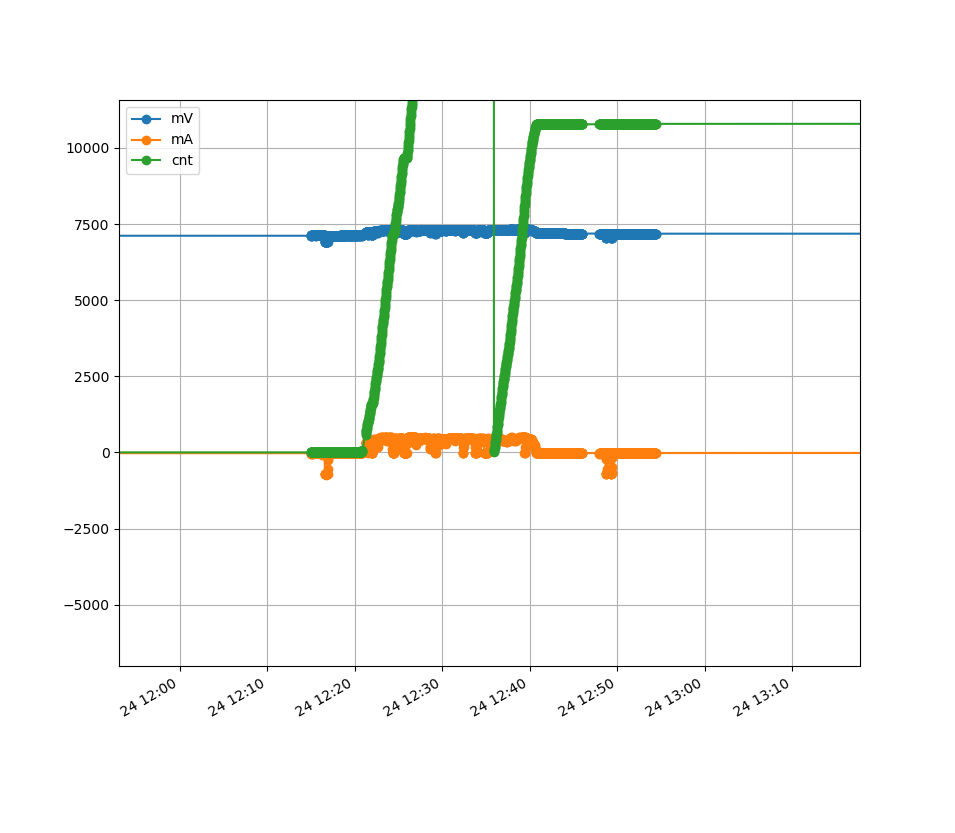

<AxesSubplot:>

In [80]:
close()
dff[['mV', 'mA', 'cnt']].plot(marker='o')

In [5]:
def veloplt(a, b):
    close()
    fig, axs = subplots(2, 1, sharex=True, figsize=(9, 7))
    dff[a].plot(ax=axs[0], marker='o')
    dff[b].plot(ax=axs[1], marker='o')
    for ax in axs:
        ax.legend()
    fig.tight_layout()

# Trip to Berkeley Bowl and back
Switching off the headlight at `19:10:30`

<IPython.core.display.Javascript object>


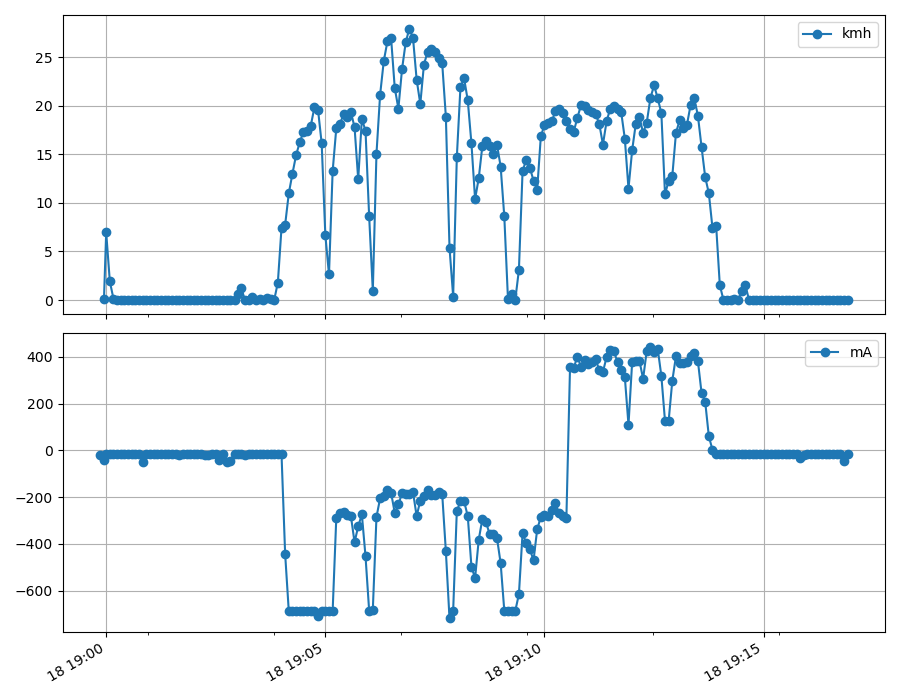

In [6]:
veloplt('kmh', 'mA')

<IPython.core.display.Javascript object>


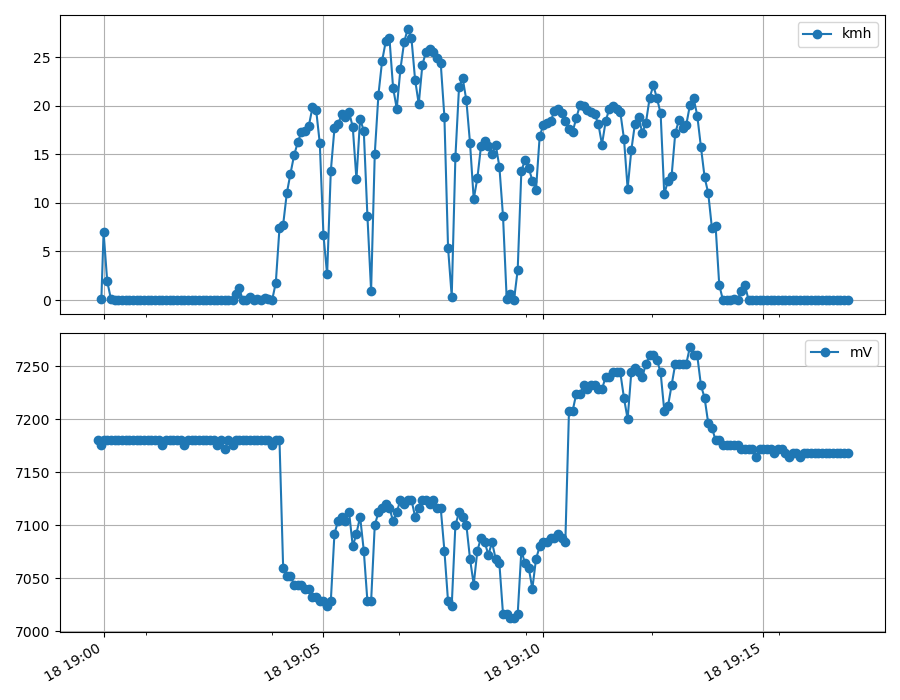

In [7]:
veloplt('kmh', 'mV')

<IPython.core.display.Javascript object>


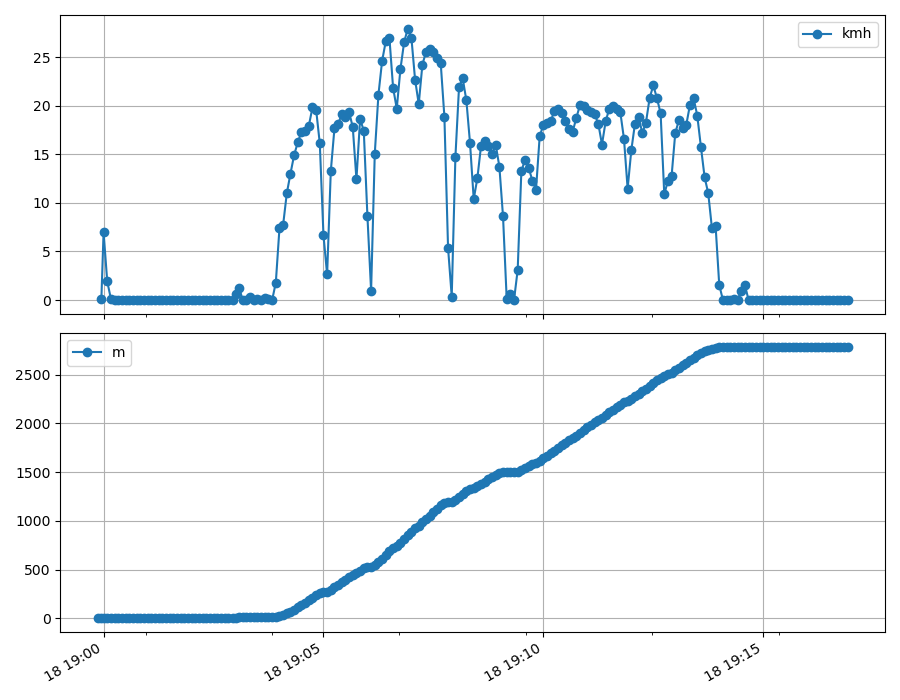

In [10]:
veloplt('kmh', 'm')

<IPython.core.display.Javascript object>


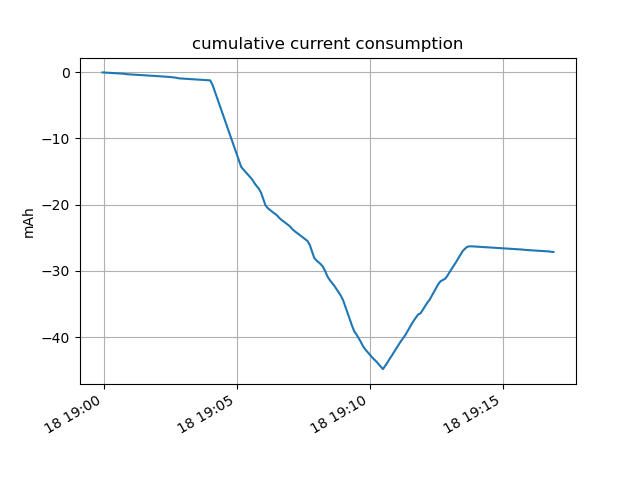

Text(0, 0.5, 'mAh')

In [11]:
close()
(dff['mA'] * dff.ts.diff() / 60 / 60).cumsum().plot()
title('cumulative current consumption')
ylabel('mAh')

In [12]:
trapz(dff['mA'], dff['ts']) / 60 / 60

-27.153333333333332